# Imports

In [1]:
import os 
import clip
import torch 
import numpy as np 
import matplotlib.pyplot as plt


from torch.backends import mps
from torchvision.datasets import CIFAR100

# device
if mps.is_available() :
    device = torch.device('mps')

elif torch.cuda.is_available() :
    device = torch.device('cuda')

else :
    device = torch.device('cpu')

print(f'CLIP Version(PyTorch) :{clip.version}')
print(f'Device :{device}')

# Load models
model, preprocess = clip.load(name='ViT-B/32', device=device, download_root='./Pre_Models/')

==========Device INFO==========
PyTorch Version :1.12.1+cpu
Device :cpu


c:\Program Files\Anaconda\envs\ML\lib\site-packages\clip\__init__.py:27: UserWarning: This PyTorch version 1.12.1 or higher is Support Metal GPU Boost!
  warnings.warn("This PyTorch version 1.12.1 or higher is Support Metal GPU Boost!")


CLIP Version(PyTorch) :1.12.1+cpu
Device :cpu


# Dataset Download 

In [2]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000020B8D419160>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [3]:
# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

Files already downloaded and verified


# Processed

In [4]:
# Prepare the inputs
image, class_id = cifar100[0]
print(f'Image Type :{type(image)}')



image_input = preprocess(image).unsqueeze(0).to(device) # processed image
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device) # processed texts


print(f'Image_inputs Shape :{image_input.shape}')
print(f'Text_inputs Shape :{text_inputs.shape}')

Image Type :<class 'PIL.Image.Image'>
Image_inputs Shape :torch.Size([1, 3, 224, 224])
Text_inputs Shape :torch.Size([100, 77])


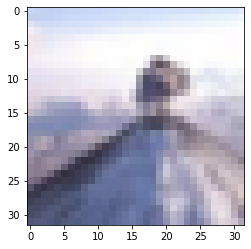

In [5]:
plt.imshow(image)
plt.show()

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize('Hello world!')

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# View the output of putting image & text data into the model

In [7]:
# Calculate features

with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

print(f'Image Features Shape :{image_features.shape}')
print(f'Text Features Shape :{text_features.shape}')

Image Features Shape :torch.Size([1, 512])
Text Features Shape :torch.Size([100, 512])


# Prediction

In [18]:
with torch.no_grad():
    Image_P, logits_per_text = model(image_input, text_inputs)

    P_Image = Image_P.softmax(dim=-1).cpu().numpy()

print(f'预测的图像的信息的大小 :{P_Image.shape}')

logits_per_image shape:  torch.Size([1, 100])
logits_per_text shape:  torch.Size([100, 1])
预测的图像的信息的大小 :(1, 100)


# 分析

In [23]:
# 将图像-文本送入网络
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# 计算余弦相似度
image_features /= image_features.norm(dim=1, keepdim=True)
text_features /= text_features.norm(dim=1, keepdim=True)
similarity = image_features @ text_features.T


print(f'logits_per_image shape:  {similarity.shape}') # 图像
print(f'logits_per_text shape:  {similarity.T.shape}') # 文本

logits_per_image shape:  torch.Size([1, 100])
logits_per_text shape:  torch.Size([100, 1])


### 上方的计算实际上是CLIP模型的forward的计算过程（等同于下方的代码）
* `similarity` = `Image_P`
* `similarity` 的转置 = `logits_per_text`

In [22]:
with torch.no_grad():
    Image_P, logits_per_text = model(image_input, text_inputs)

logits_per_image shape:  torch.Size([1, 100])
logits_per_text shape:  torch.Size([100, 1])


### 模型的计算过程
```python
def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)# <<<<====这里的shape[batch, text_nums]

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()# <<<<====将图像特征和文本特征(已经转置)相乘
        #
        print(f'logits_per_image shape:  {logits_per_image.shape}')
        logits_per_text = logits_per_image.t() # <<<<====这里将图像的预测结果进行转置得出文本的预测信息
        #
        print(f'logits_per_text shape:  {logits_per_text.shape}') 

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text
```